In [1]:
import warnings
from pylj import comp, md, sample, util
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# The ideal gas law

## Molecular dynamics

Molecular dynamics simulation is a commonly applied, and powerful, technique in many aspects of computational chemistry for the determination of equilibrium & transport properties of a given chemical system. The idea is simple: calculate the forces acting on the atoms in a system and analyse their time-dependent behaviour and motion using Newtonian mechanics, and when enough information on the motion of the atoms, deduce the properties of the system.  

The aim of this exercise to use molecular dynamics simulation to investigate the nautre of an ideal gas. This involves the 2-dimensional simulation of argon using [pylj](pythoninchemistry.org/pylj). The function defined below is a typical molecular dynamics simulation where the number of particles, volume of the system, and system temperature are kept constant (this is referred to as the NVT ensemble). 

Shown below is an example of Python code that can be used to run a molecular dyanmics simulation in the NVT ensemble using pylj. 

In [2]:
def md_simulation(number_of_particles, temperature, box_length, number_of_steps, sample_frequency):
    # Creates the visualisation environment
    %matplotlib notebook
    # Initialise the system
    system = md.initialise(number_of_particles, temperature, box_length, 'square')
    # This sets the sampling class
    sample_system = sample.Energy(system)
    # Start at time 0
    system.time = 0
    # Begin the molecular dynamics loop
    for i in range(0, number_of_steps):
        # At each step, calculate the forces on each particle 
        # and get acceleration
        system.particles, system.distances, system.forces, system.energies = comp.compute_forces(system.particles, 
                                                                                                 system.box_length)
        # Run the equations of motion integrator algorithm
        system.particles = md.velocity_verlet(system.particles, system.timestep_length, system.box_length)
        # Sample the thermodynamic and structural parameters of the system
        system = md.sample(system.particles, system.box_length, system.initial_particles, system)
        # Allow the system to interact with a heat bath
        system.particles = comp.heat_bath(system.particles, system.temperature_sample, temperature)
        # Iterate the time
        system.time += system.timestep_length
        system.step += 1
        # At a given frequency sample the positions and plot the RDF
        if system.step % sample_frequency == 0:
            sample_system.update(system)
    return system

This allows a simulation of an arbitrary number of particles at an arbitrary temperature and in a cell of an arbitrary volume. Below we run a simulation of 50 particles at 0 $^\circ$C in a cell of 10000 Å$^2$. 

<IPython.core.display.Javascript object>


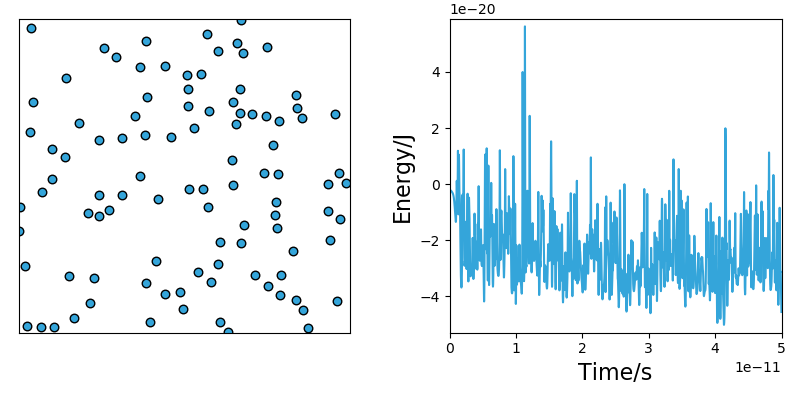

In [3]:
system = md_simulation(100, 273.15, 100, 5000, 50)

## Ideal gas law

We are wanting to investigate the nature of the gas ideality. An ideal gas is one that:
- consists of point particles 
- that interact by completely elastic collisions 
- and obey the following relationship,

$$ p = \frac{Nk_BT}{V}, $$

where pressure, $p$, is the observable. This is given as an output plot by pylj and any of $N$, $T$, or $V$ can be varied to investigate this relationship.

It is possible to return the average pressure during the entire simulation using the following command. 

In [ ]:
print("Average pressure = {:.2e} +/- {:.2e} N/m".format(system.pressure_sample.mean(), 
                                                        system.pressure_sample.std()))

However, it is noted that when the system is not an ideal gas (as is the case with real argon) there may be deviation from the ideal gas law that can be modelled with the van der Waals equation

$$ \bigg[p + a \frac{N^2}{V^2}\bigg]\bigg[\frac{V}{N}-b\bigg] = k_BT $$

The aim of this exercise is to **design and execute** a computational experiment to investigate the ideal gas law, and any deviation from it that is observed. As a result, calculate values for $a$ and $b$ in the van der Waals equation.